# Neural Style Transfer

### Import문
없는 모듈은 `poetry add <모듈명>`으로 추가해주세요.   
python은 django 심화 강의에서와 마찬가지로 3.9.9로 진행해주세요

In [123]:
import tensorflow as tf
import tensorflow_hub as hub

import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image

### GPU가 있는지 확인하기
CUDA Driver가 정상적으로 설치됐다면 아래 명령어에서 리스트에 무언가 담겨있을 겁니다.

In [131]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [124]:
def image2tensor(image):
    
    if isinstance(image, str):
        image = PIL.Image.open(image)
    else:
        pass
    
    np_image = tf.keras.utils.img_to_array(image)
    tf_image = tf.convert_to_tensor(np_image, dtype=tf.float32)
    
    shape = tf.cast(tf_image.shape[:-1], tf.float32)
    max_dim = 512
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    
    resized_image = tf.image.resize(tf_image, new_shape) / 255.
    expanded_image = resized_image[tf.newaxis, :]
    return expanded_image

In [125]:
def tensor2image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [ ]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

In [126]:
content_path = "tfapp/static/content_images/content1.jpeg"
style_path = "tfapp/static/style_images/style1.jpeg"

In [128]:
content_image = image2tensor(content_path)
style_image = image2tensor(style_path)

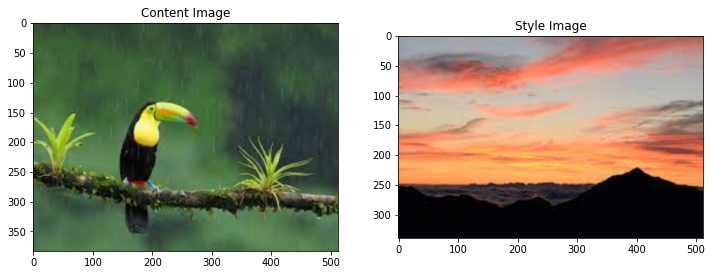

In [129]:
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

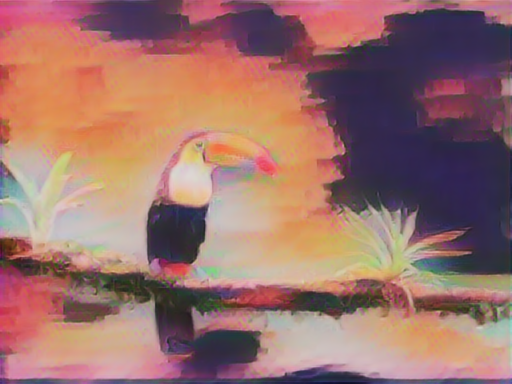

In [130]:
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(content_image, style_image)[0]
tensor_to_image(stylized_image)

## Neural Style Transfer 직접 다뤄보기
아까 수업 때 이야기한 걸 복기하면서 하나씩 구현해보기.

### 1. 훈련된 VGG19를 불러온다.
수업에서 언급했듯, 우선 불러온 모델의 정확도가 어떤지 확인해보자.

In [132]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [11]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

49152/35363 [=========================================] - 0s 0us/step


[('toucan', 0.9960814),
 ('hornbill', 0.0038572263),
 ('goldfinch', 1.2353916e-05),
 ('black_stork', 6.9034872e-06),
 ('white_stork', 6.793439e-06)]

1순위에 **toucan**이 나오는 거보니 모델의 분류 성능은 좋아 보인다.

## 2. 어느 레이어에서 

In [12]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)

80150528/80134624 [==============================] - 7s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [13]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [14]:
def vgg_layers(layer_names):
  """ 중간층의 출력값을 배열로 반환하는 vgg 모델을 만듭니다."""
  # 이미지넷 데이터셋에 사전학습된 VGG 모델을 불러옵니다
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [15]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

# 각 층의 출력에 대한 통계량을 살펴봅니다
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  크기: ", output.numpy().shape)
  print("  최솟값: ", output.numpy().min())
  print("  최댓값: ", output.numpy().max())
  print("  평균: ", output.numpy().mean())
  print()

block1_conv1
  크기:  (1, 340, 512, 64)
  최솟값:  0.0
  최댓값:  672.19214
  평균:  26.565659

block2_conv1
  크기:  (1, 170, 256, 128)
  최솟값:  0.0
  최댓값:  3268.1372
  평균:  116.260155

block3_conv1
  크기:  (1, 85, 128, 256)
  최솟값:  0.0
  최댓값:  6724.9126
  평균:  98.67296

block4_conv1
  크기:  (1, 42, 64, 512)
  최솟값:  0.0
  최댓값:  10841.673
  평균:  394.4059

block5_conv1
  크기:  (1, 21, 32, 512)
  최솟값:  0.0
  최댓값:  1870.9054
  평균:  29.171026



In [16]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [17]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "[0,1] 사이의 실수 값을 입력으로 받습니다"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

In [15]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('스타일:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    크기: ", output.numpy().shape)
  print("    최솟값: ", output.numpy().min())
  print("    최댓값: ", output.numpy().max())
  print("    평균: ", output.numpy().mean())
  print()

print("콘텐츠:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    크기: ", output.numpy().shape)
  print("    최솟값: ", output.numpy().min())
  print("    최댓값: ", output.numpy().max())
  print("    평균: ", output.numpy().mean())

스타일:
   block1_conv1
    크기:  (1, 64, 64)
    최솟값:  0.00029406167
    최댓값:  16431.607
    평균:  265.80948

   block2_conv1
    크기:  (1, 128, 128)
    최솟값:  0.0
    최댓값:  51765.996
    평균:  6409.9443

   block3_conv1
    크기:  (1, 256, 256)
    최솟값:  0.0
    최댓값:  382028.47
    평균:  6081.767

   block4_conv1
    크기:  (1, 512, 512)
    최솟값:  0.0
    최댓값:  3830034.0
    평균:  97353.86

   block5_conv1
    크기:  (1, 512, 512)
    최솟값:  0.0
    최댓값:  61140.625
    평균:  851.00665

콘텐츠:
   block5_conv2
    크기:  (1, 23, 32, 512)
    최솟값:  0.0
    최댓값:  1216.8822
    평균:  9.8395815


In [16]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight=1e-2
content_weight=1e4

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [17]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

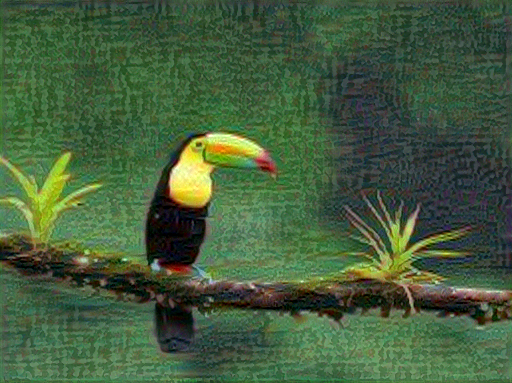

In [20]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

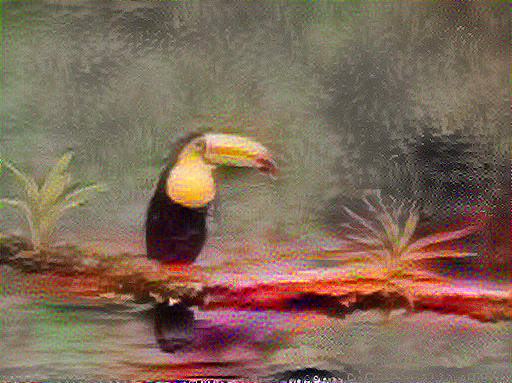

훈련 스텝: 400
....................................................

In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("훈련 스텝: {}".format(step))

end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))

In [11]:
tf.keras.applications.vgg19.preprocess_input(content_image)

<tf.Tensor: shape=(1, 422, 512, 3), dtype=float32, numpy=
array([[[[-103.54914 , -116.13031 , -123.05092 ],
         [-103.57102 , -116.15652 , -123.079285],
         [-103.576775, -116.165794, -123.090324],
         ...,
         [-103.61201 , -116.22063 , -123.153   ],
         [-103.64167 , -116.248535, -123.18091 ],
         [-103.66324 , -116.267944, -123.20032 ]],

        [[-103.569984, -116.149   , -123.07393 ],
         [-103.56897 , -116.15349 , -123.0782  ],
         [-103.566055, -116.15507 , -123.0796  ],
         ...,
         [-103.61759 , -116.22405 , -123.156425],
         [-103.61355 , -116.219215, -123.15159 ],
         [-103.61159 , -116.21629 , -123.14867 ]],

        [[-103.594185, -116.17143 , -123.099884],
         [-103.57267 , -116.1564  , -123.082695],
         [-103.55923 , -116.144936, -123.079384],
         ...,
         [-103.61289 , -116.2176  , -123.14997 ],
         [-103.59189 , -116.19659 , -123.12896 ],
         [-103.58316 , -116.18787 , -123.12024

### Few Lines of shortcuts with TensorFlow-Hub
사실 위의 모든 과정은 미리 훈련된 **Pre-trained** 모델을 불러오면 고민이 없어집니다.

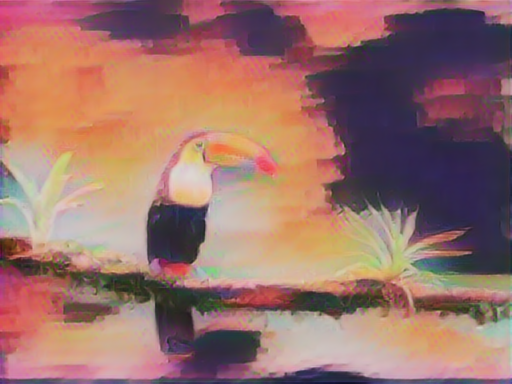

In [15]:
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(content_image, style_image)[0]
tensor_to_image(stylized_image)

In [22]:
stylized_image.shape

TensorShape([1, 384, 512, 3])

In [9]:
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

NameError: name 'content_image' is not defined

In [23]:
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
import PIL.Image


def image2tensor(img):
    max_dim = 512
    img = tf.keras.utils.img_to_array(img)
    img = tf.convert_to_tensor(img, dtype=tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    max_dim = 512
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img


def tensor2image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [115]:
def image2tensor(image):
    
    if isinstance(image, str):
        image = PIL.Image.open(image)
    else:
        pass
    
    np_image = tf.keras.utils.img_to_array(image)
    tf_image = tf.convert_to_tensor(np_image, dtype=tf.float32)
    
    shape = tf.cast(tf_image.shape[:-1], tf.float32)
    max_dim = 512
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    
    resized_image = tf.image.resize(tf_image, new_shape) / 255.
    expanded_image = resized_image[tf.newaxis, :]
    return expanded_image

In [116]:
content = image2tensor(content_path)
style = image2tensor(style_path)

In [74]:
pil_content = PIL.Image.open(content_path)
pil_style = PIL.Image.open(style_path)

In [75]:
np_content = tf.keras.utils.img_to_array(pil_content)
np_style = tf.keras.utils.img_to_array(pil_style)

In [76]:
tf_content = tf.convert_to_tensor(np_content, dtype=tf.float32)
tf_style = tf.convert_to_tensor(np_style, dtype=tf.float32)

In [102]:
mean = tf.convert_to_tensor([0.485, 0.456, 0.406], dtype=tf.float32)
std = tf.convert_to_tensor([0.229, 0.224, 0.225], dtype=tf.float32)

In [104]:
shape = tf.cast(tf.shape(tf_content)[:-1], tf.float32)
max_dim = 512
long_dim = max(shape)
scale = max_dim / long_dim

new_shape = tf.cast(shape * scale, tf.int32)
tfresized_content = tf.image.resize(tf_content, new_shape) / 255.0
normalized_content = (tfresized_content - mean) / std

In [105]:
shape = tf.cast(tf.shape(tf_style)[:-1], tf.float32)
max_dim = 512
long_dim = max(shape)
scale = max_dim / long_dim

new_shape = tf.cast(shape * scale, tf.int32)
tfresized_style = tf.image.resize(tf_style, new_shape) / 255.0
normalized_style = (tfresized_style - mean) / std

In [106]:
expanded_content = normalized_content[tf.newaxis, :]
expanded_style = normalized_style[tf.newaxis, :]

In [119]:
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(content, style)[0]

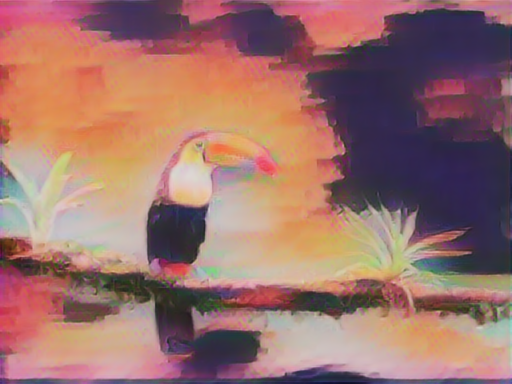

In [120]:
tensor_to_image(stylized_image)

In [ ]:
from PIL.Image import Image
import numpy as np
import tensorflow as tf

# 이미지 경로
image_path: str = "image.jpeg"

# PIL로 불러오기
pil_image: Image = Image.open(pil_image)

# PIL > np.ndarray
np_image: np.ndarray = tf.keras.utils.image_to_array(pil_image)

# np.ndarray > tf.Tensor
tf_image: tf.Tensor = tf.convert_to_tensor(np_image, dtype=tf.float32)

# tf.Tensor 형변환하기
# 1. 모델에 맞게 Resize 해주기
# 2. 차원수 늘려주기

# Resize: 더 긴 변을 512로 맞춰주기
shape = tf.cast(tf.shape(tf_image)[:-1], tf.float32)

max_dim = 512
long_dim = max(shape)
scale = max_dim / long_dim

new_shape = tf.cast(shape * scale, tf.int32)

resized_image = tf.image.resize(tf_image, new_shape)

# 차원수 늘려주기
expanded_image = resized_image[tf.newaxis, :]

## What can we do?
그래서 우리가 여기서 할 수 있는 선택지는 뭐가 있을까요? 배포 관점에서 생각해봅시다.

1. AI + 백엔드 개발자로 거듭나기 위해서 가져야하는 덕목은
  + 내가 지금 사용/구현하려는 기술이 어떤 기술인지 이해했는가
  + 이 모델을 잘 훈련시킬 수 있는가?
  + 현재 상황과 자원에 맞는 모델을 만들어낼 수 있는가? (혹은 가져올 수 있는가?)

2. 여기서 그렇다면 ...
+ 기술은 알겠는데 저걸 어느 세월에 훈련시키지? 그냥 Pre-trained를 사용한자.
  + 여기서 고려할 점은 모델이 너무 크면 Inference하는데 시간이 오래 걸린다는 것입니다. Pre-trained weight 중에 경량화가 진행되었거나 더 가벼운 모델의 백본을 찾아봅니다. 혹은 더 빠르게 구현된 최신 기술이 있는지 찾아봅니다.
+ 내가 직접 훈련해서 더 다양한 결과를 얻고 싶어
  + 이도 좋은 방법이다. 여기서 기본 hyperparameter에서 다른 값들을 줘서 훈련해보는 방법도 있습니다.
  +